# Segmentation

In [33]:
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt 
import numpy as np

from MRIsegm.processing import otsu_thresholding, apply_mask

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Constants

In [34]:
SEED = 33
BATCH_SIZE_TRAIN = 5
BATCH_SIZE_TEST = 2

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

NUM_OF_EPOCHS = 100

NUM_TRAIN = 375
NUM_TEST = 94

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

data_dir_test = '../data/test'
data_dir_test_img = os.path.join(data_dir_test, 'img')
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

In [35]:
def reduce_image_features(img):

    reduced_img = np.zeros_like(img)

    for layer in range(0, img.shape[0]):

        im = img[layer,:,:]
        im = np.uint8(im)
        otsu = otsu_thresholding(im)
        reduced = apply_mask(im, otsu)
        reduced= np.float32(reduced)

        reduced_img[layer,:,:] = reduced


    return reduced_img

In [36]:
def create_segmentation_generator_train(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args_img = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3
#                       preprocessing_function=reduce_image_features
    )

    data_gen_args_mask = dict(rescale=1./255,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
                     zoom_range=0.3
    )



    img_data_gen = ImageDataGenerator(**data_gen_args_img)
    mask_data_gen = ImageDataGenerator(**data_gen_args_mask)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)


    #! do not perform data augmentation in the test generator
def create_segmentation_generator_test(img_path, mask_path, BATCH_SIZE, IMG_SIZE, SEED):

    data_gen_args = dict(rescale=1./255)

    img_data_gen = ImageDataGenerator(**data_gen_args)
    mask_data_gen = ImageDataGenerator(**data_gen_args)

    img_generator = img_data_gen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    mask_generator = mask_data_gen.flow_from_directory(mask_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)

    return zip(img_generator, mask_generator)

In [37]:
train_generator = create_segmentation_generator_train(data_dir_train_img, data_dir_train_mask, BATCH_SIZE_TRAIN, IMG_SIZE, SEED)

test_generator = create_segmentation_generator_test(data_dir_test_img, data_dir_test_mask, BATCH_SIZE_TEST, IMG_SIZE, SEED)

Found 375 images belonging to 1 classes.
Found 375 images belonging to 1 classes.
Found 94 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


In [38]:
def display(display_list):
    plt.figure(figsize=(12,8))
    title = ['Input image', 'True Mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

In [39]:
def show_dataset(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        display([image[0], mask[0]])


### Show trainig data

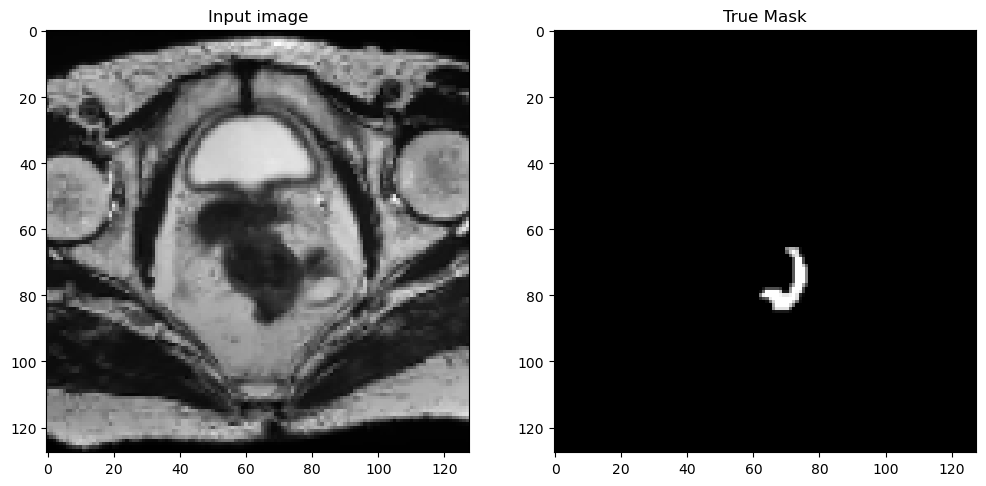

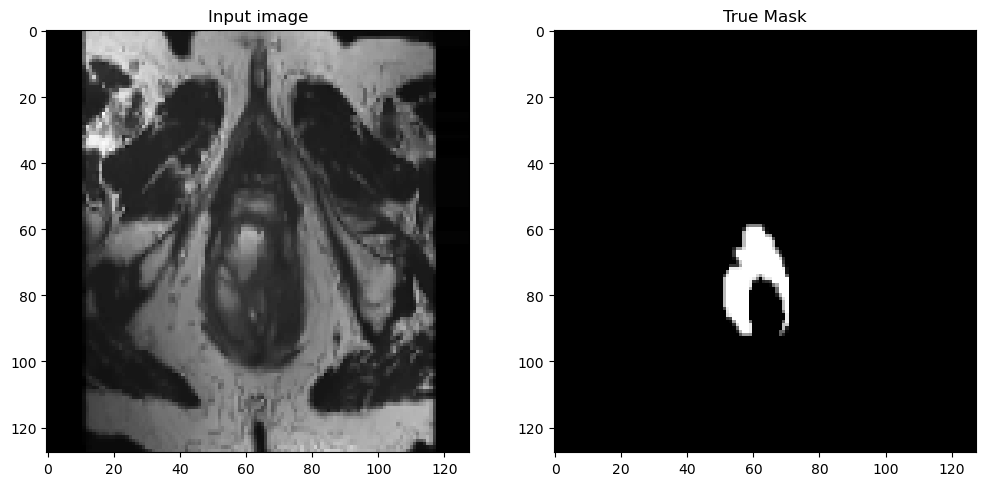

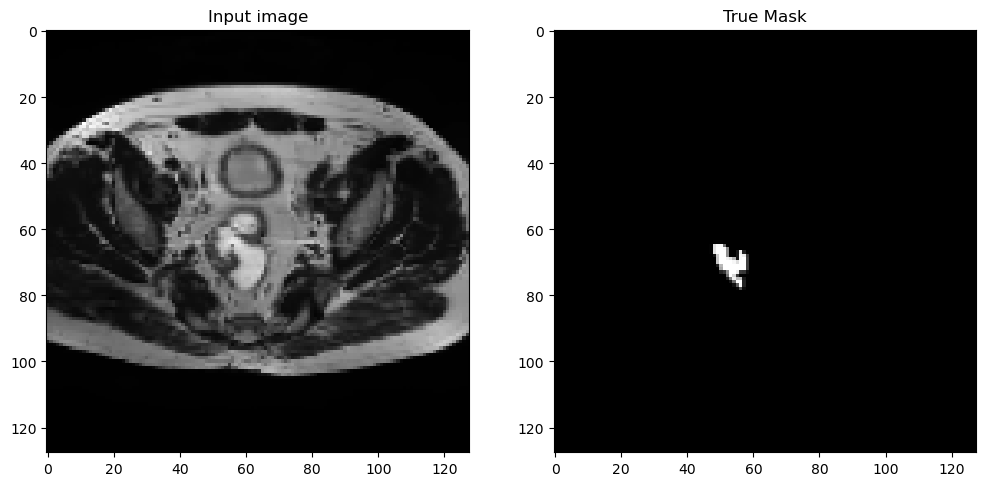

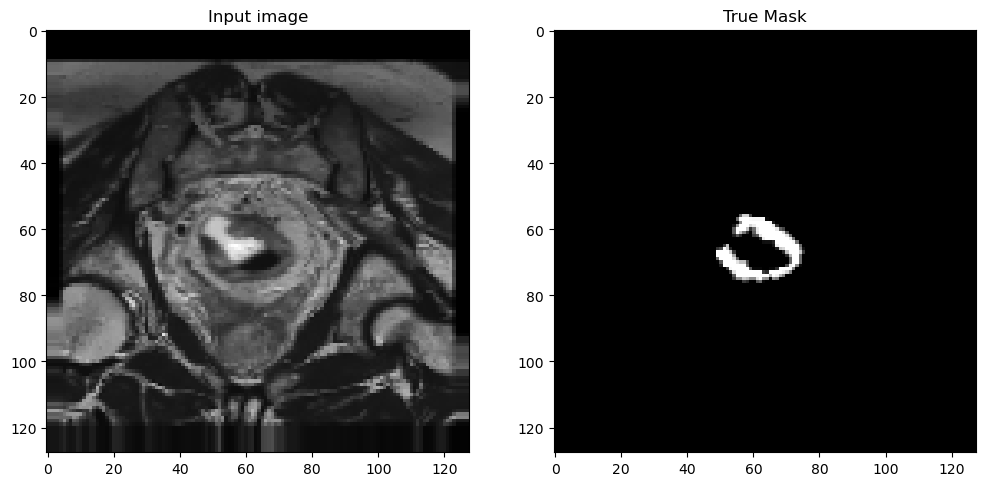

In [40]:
show_dataset(train_generator, 4) # training

### Show test data

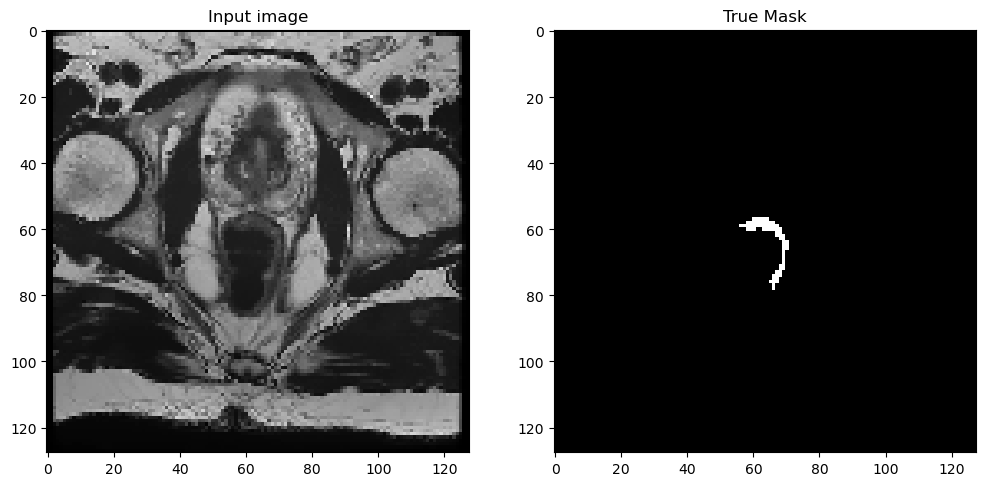

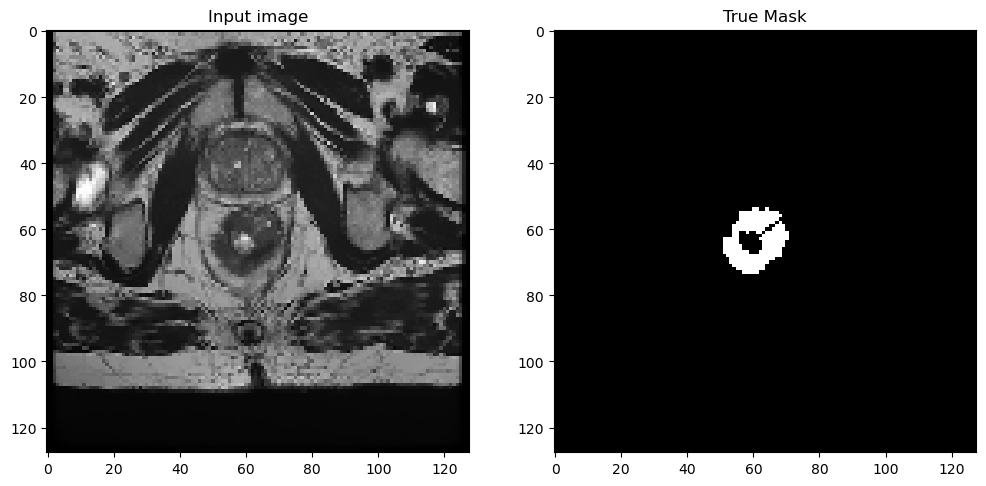

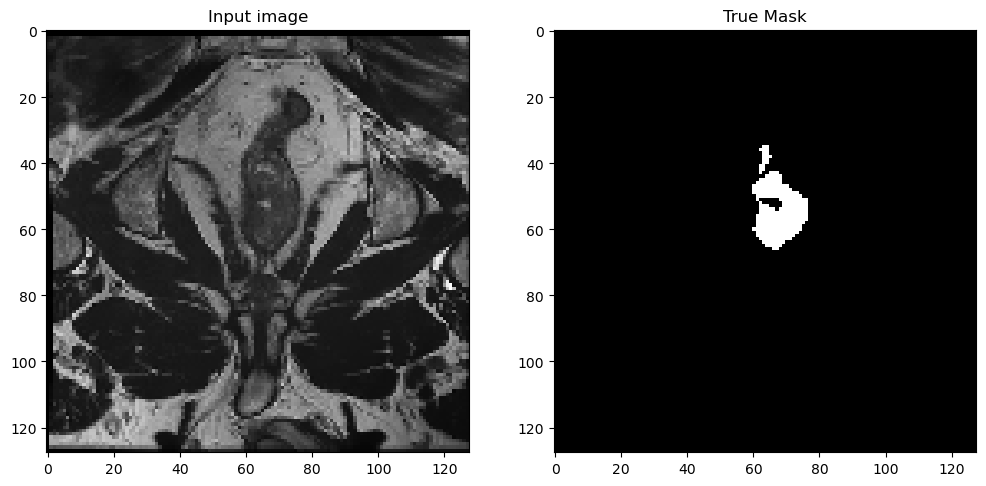

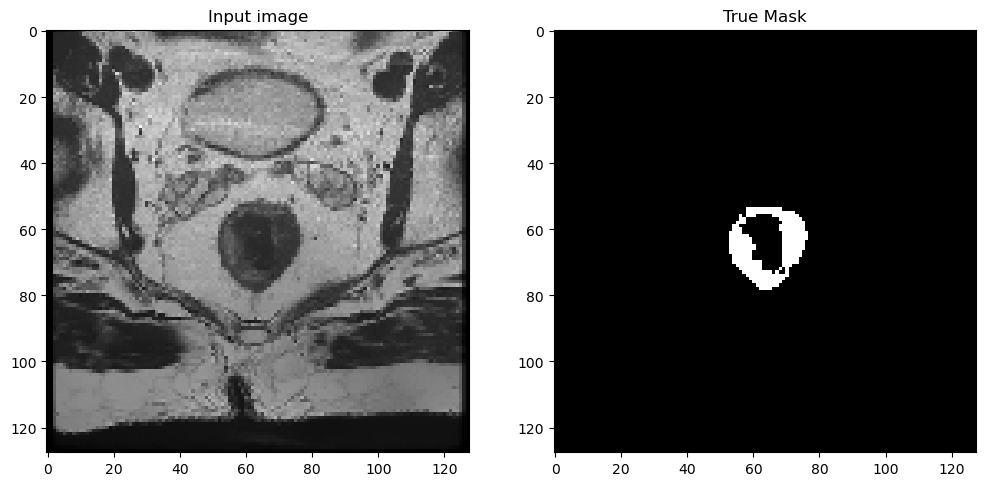

In [41]:
show_dataset(test_generator, 4) # test

## U-Net Model

In [42]:
def unet(n_levels=4, initial_features=64, n_conv=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = tf.keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = tf.keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = tf.keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_conv):
            x = tf.keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [43]:
model = unet()

metrics = [ tf.keras.metrics.MeanIoU(num_classes=2),
            'accuracy'
           ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

model.summary()

Model: "UNET-L4-F64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_16[0][0]                  
________________________________________________________________________________________

In [44]:


callbacks = [

   tf.keras.callbacks.ModelCheckpoint('../data/models/' + model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}' + "_checkpoint" + '_zoomed' + ".h5", save_best_only=True),
   #tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min')
]

history = model.fit(train_generator,
            steps_per_epoch=EPOCH_STEP_TRAIN, 
            validation_data=test_generator, 
            validation_steps=EPOCH_STEP_TEST,
            epochs=NUM_OF_EPOCHS,
            callbacks=callbacks)



Epoch 1/100
75/75 [==============================] - 79s 1s/step - loss: 0.2678 - mean_io_u_1: 0.4965 - accuracy: 0.9373 - val_loss: 0.0582 - val_mean_io_u_1: 0.4940 - val_accuracy: 0.9880
Epoch 2/100
75/75 [==============================] - 77s 1s/step - loss: 0.0520 - mean_io_u_1: 0.4962 - accuracy: 0.9868 - val_loss: 0.0548 - val_mean_io_u_1: 0.4937 - val_accuracy: 0.9873
Epoch 3/100
75/75 [==============================] - 78s 1s/step - loss: 0.0476 - mean_io_u_1: 0.4963 - accuracy: 0.9869 - val_loss: 0.0538 - val_mean_io_u_1: 0.4935 - val_accuracy: 0.9870
Epoch 4/100
75/75 [==============================] - 79s 1s/step - loss: 0.0440 - mean_io_u_1: 0.4966 - accuracy: 0.9878 - val_loss: 0.0449 - val_mean_io_u_1: 0.4943 - val_accuracy: 0.9886
Epoch 5/100
75/75 [==============================] - 78s 1s/step - loss: 0.0434 - mean_io_u_1: 0.4954 - accuracy: 0.9847 - val_loss: 0.0452 - val_mean_io_u_1: 0.4936 - val_accuracy: 0.9873
Epoch 6/100
75/75 [==============================] - 79

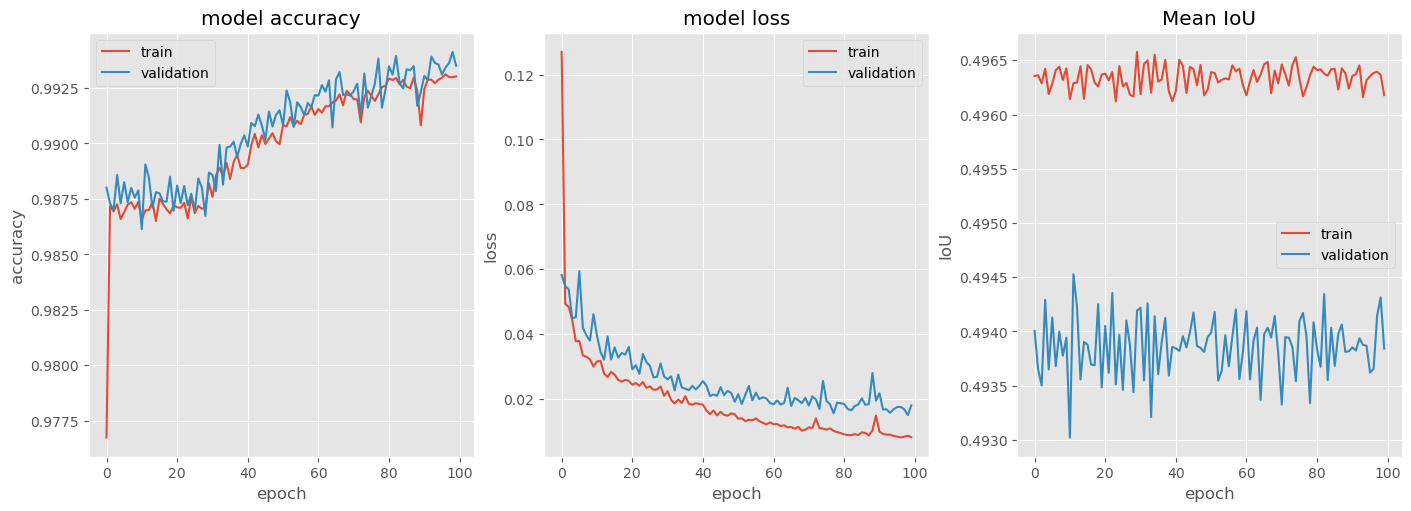

In [46]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 3, figsize=(14, 5), constrained_layout=True)
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'validation'], loc='best')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'validation'], loc='best')

ax[2].plot(history.history['mean_io_u_1'])
ax[2].plot(history.history['val_mean_io_u_1'])
ax[2].set_title('Mean IoU')
ax[2].set_ylabel('IoU')
ax[2].set_xlabel('epoch')
ax[2].legend(['train', 'validation'], loc='best')

plt.show()

In [47]:
model.save('../data/models/' + model.name + f'_{IMAGE_HEIGHT}_{IMAGE_WIDTH}' + '_zoomed' + '.h5')

In [48]:
test_generator = create_segmentation_generator_test(data_dir_test_img, data_dir_test_mask, 1, IMG_SIZE, SEED)

Found 94 images belonging to 1 classes.
Found 94 images belonging to 1 classes.


In [49]:
def show_prediction(datagen, num=1):
    for i in range(0, num):
        image, mask = next(datagen)
        pred_mask = model.predict(image) 
        display([image[0], mask[0], pred_mask[0]>0.5])

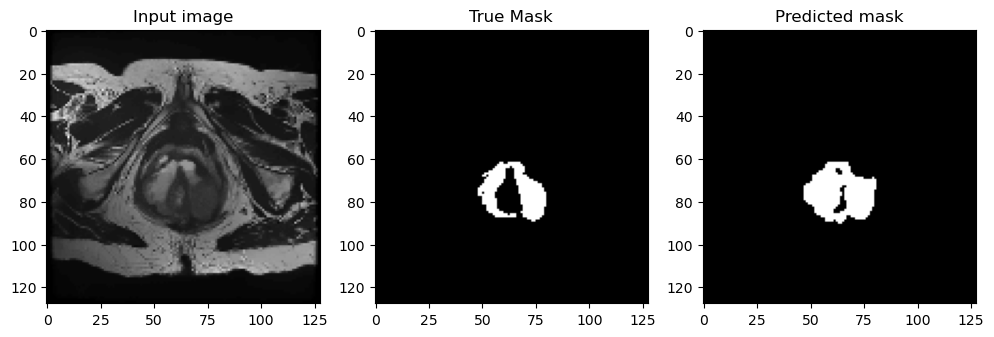

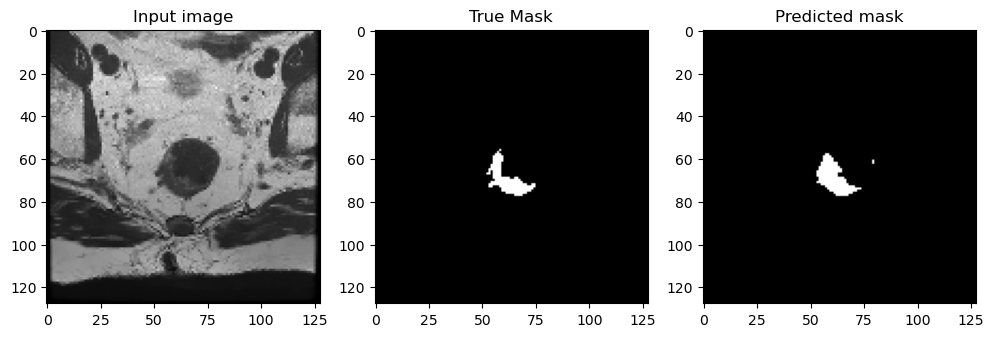

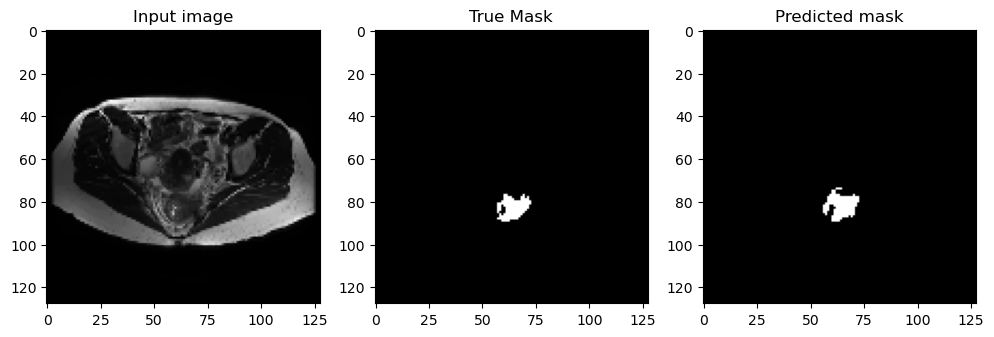

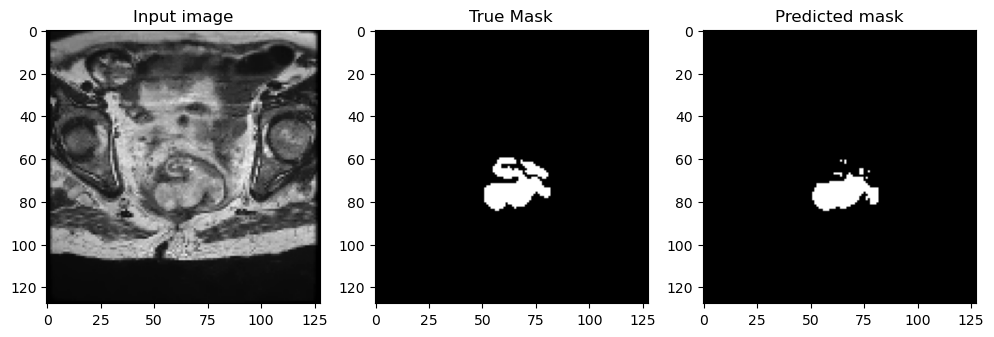

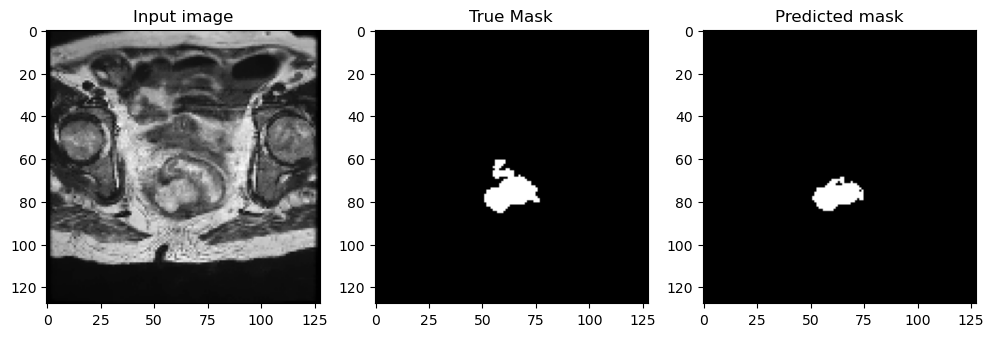

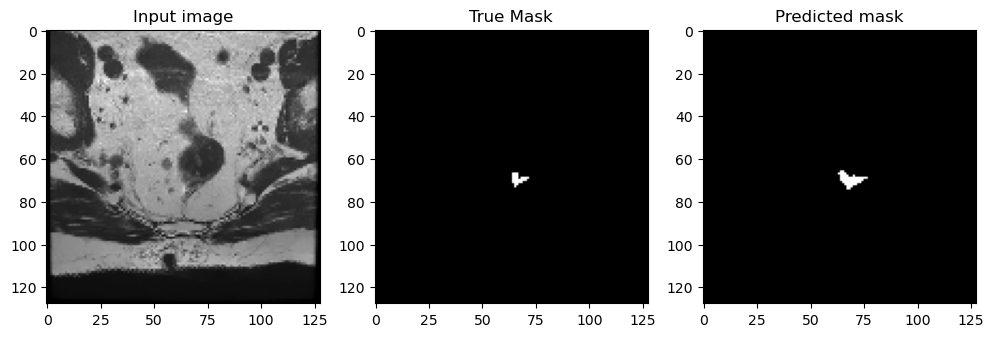

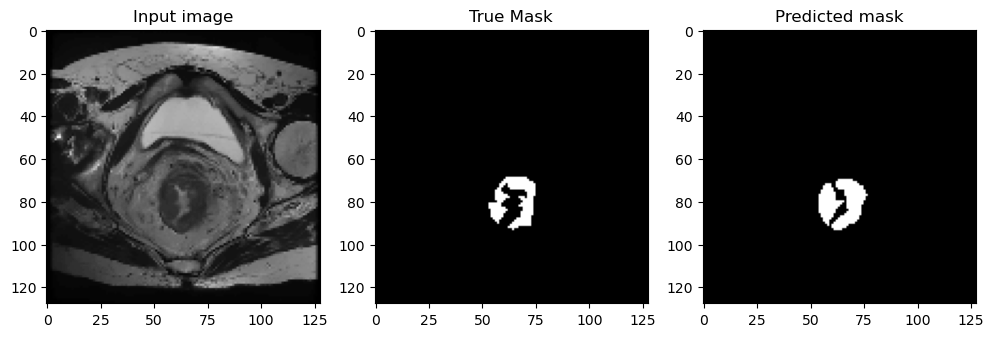

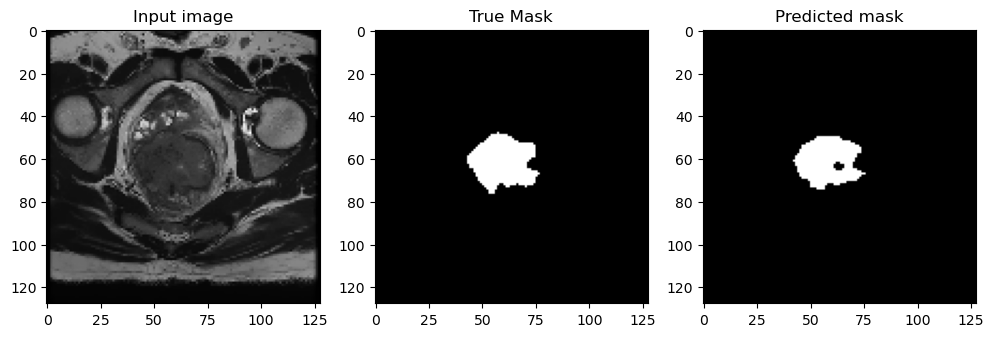

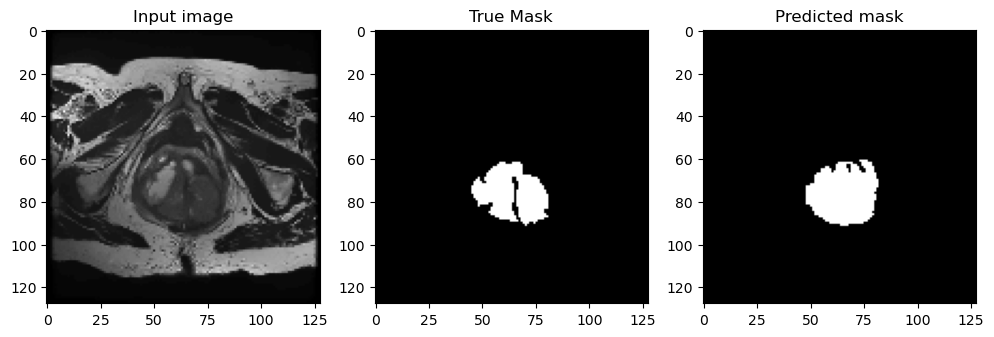

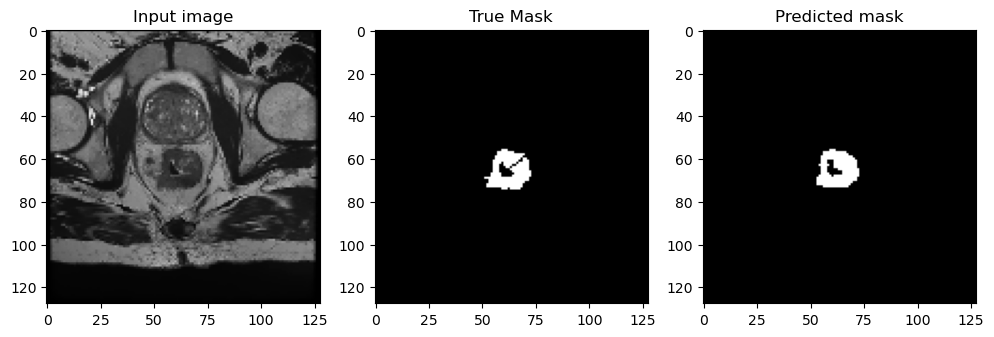

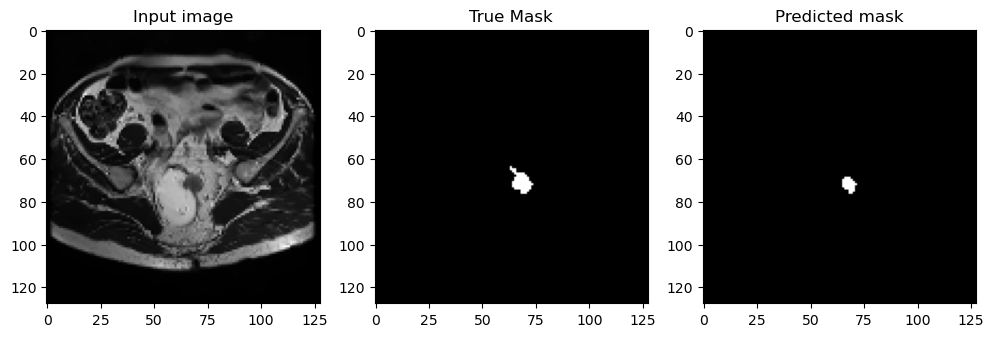

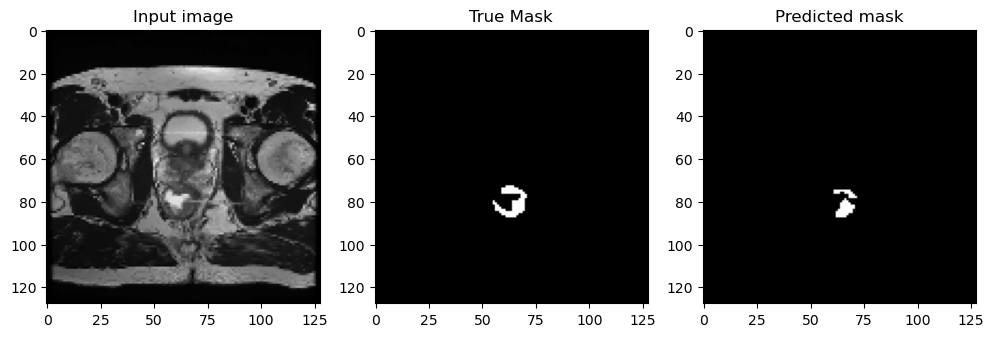

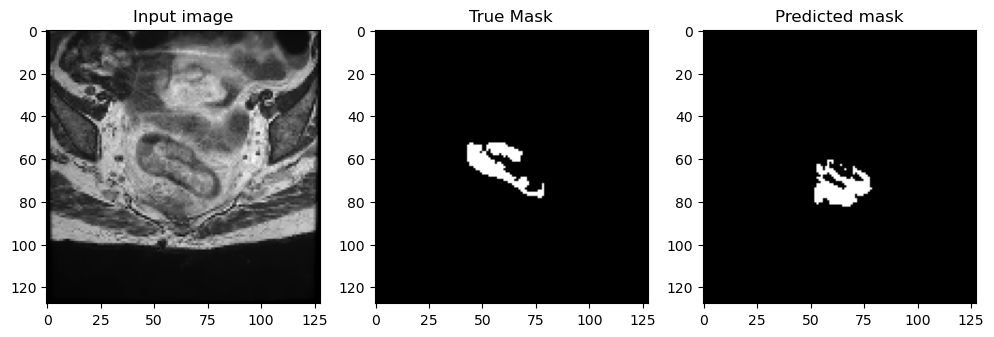

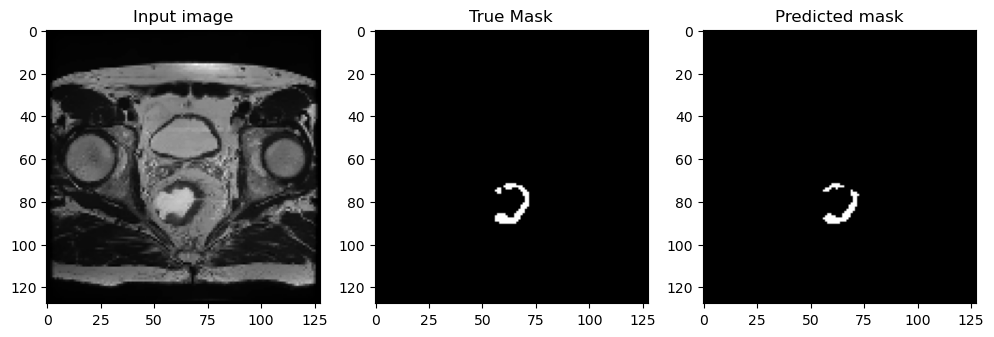

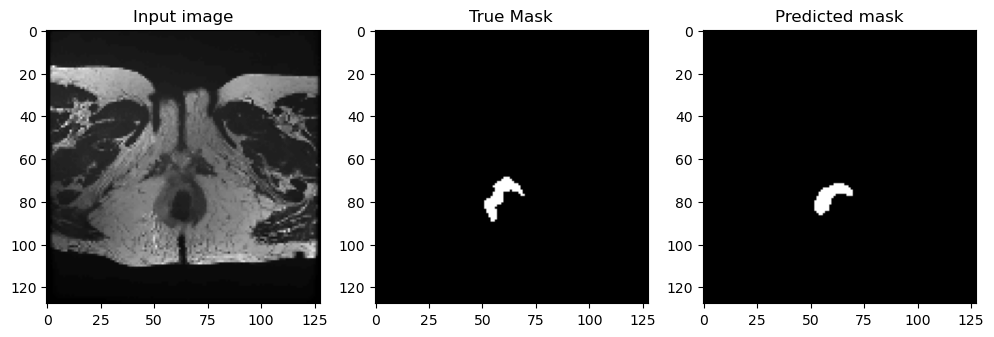

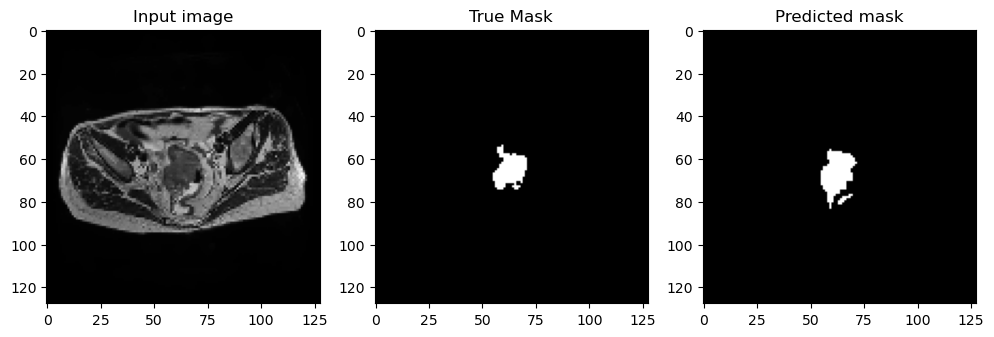

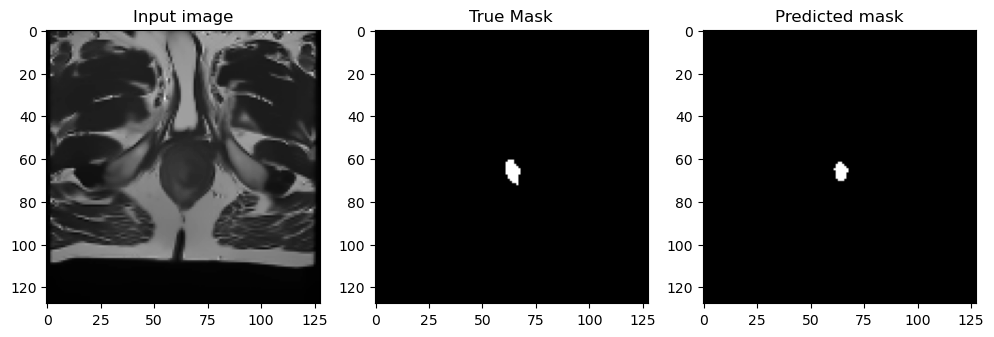

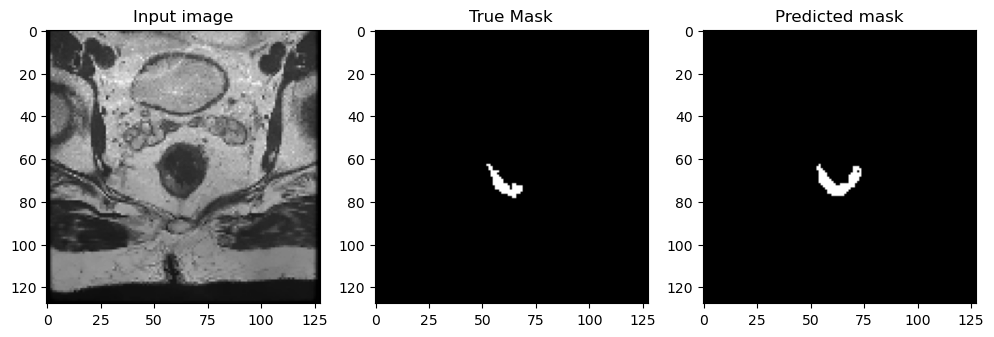

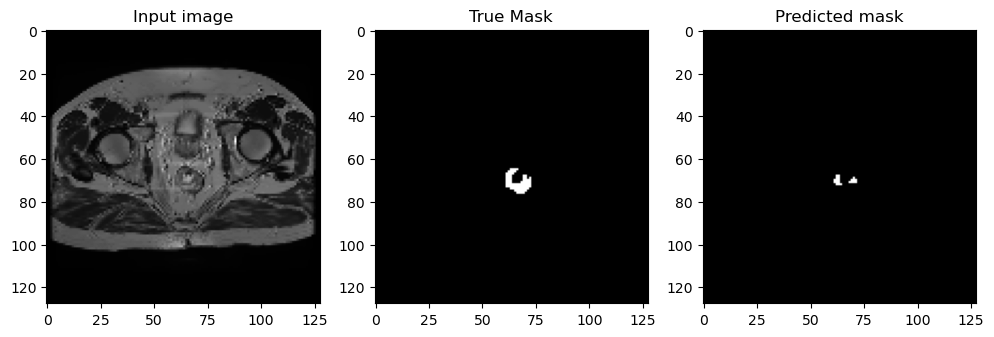

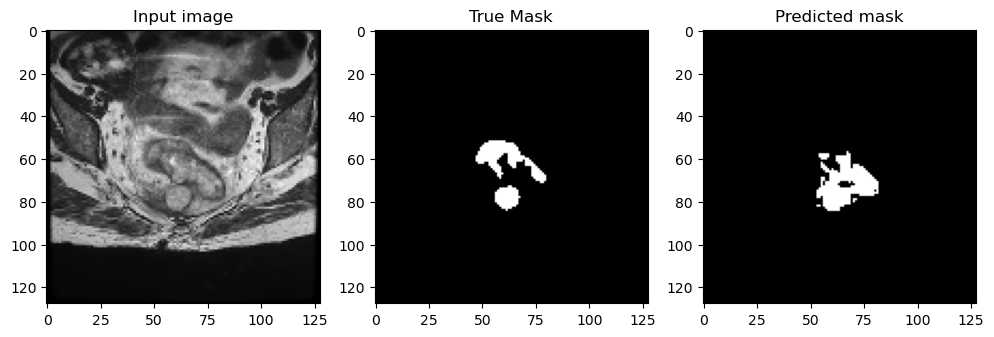

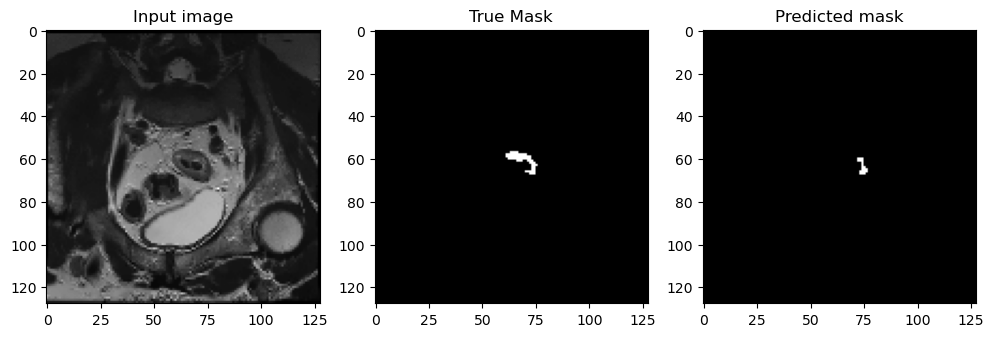

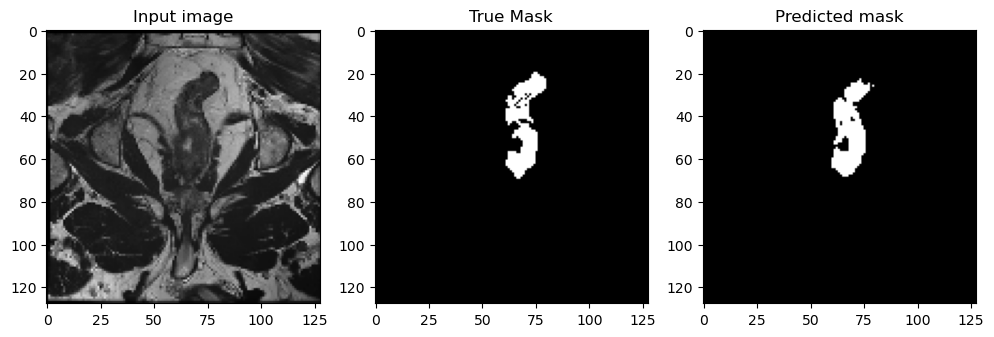

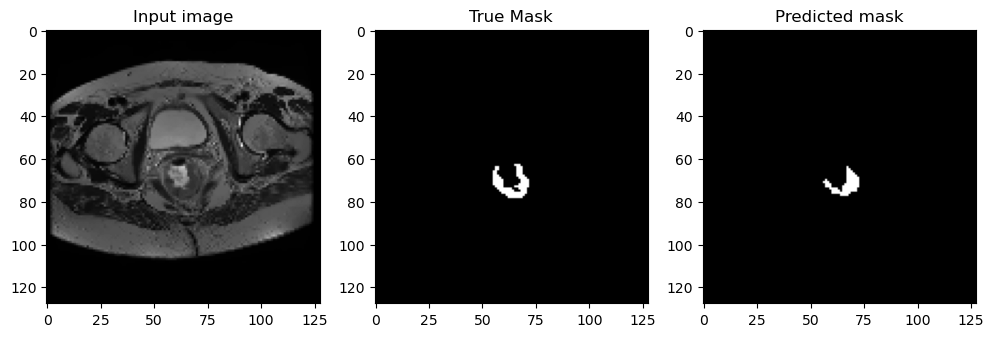

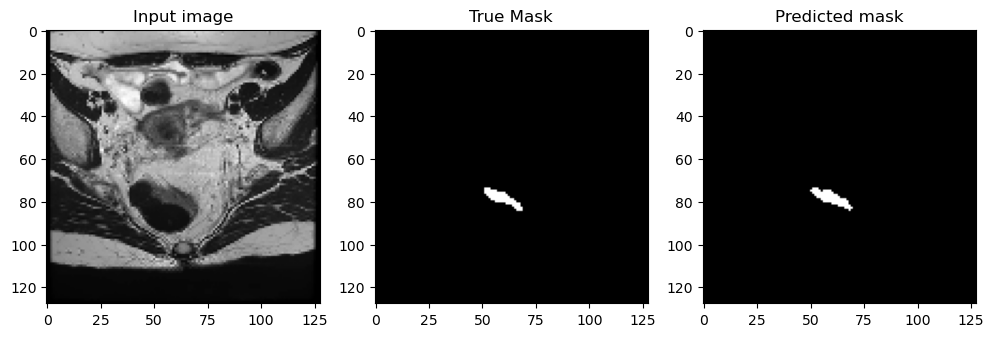

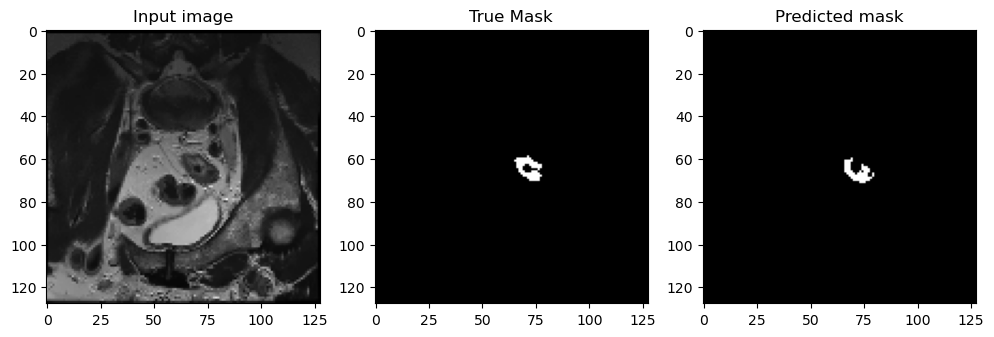

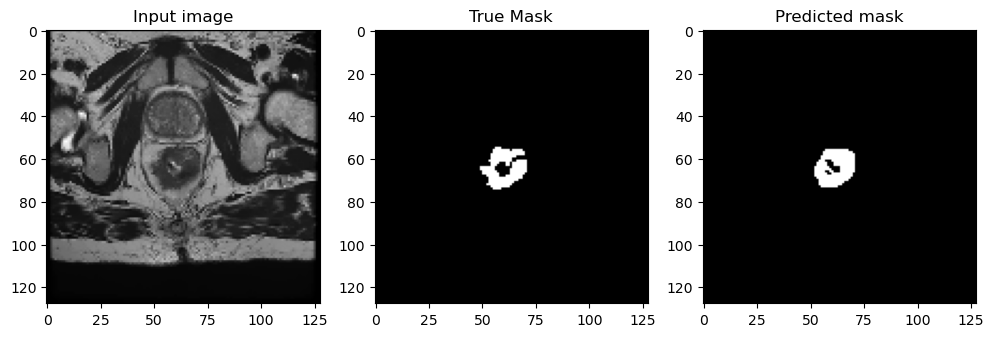

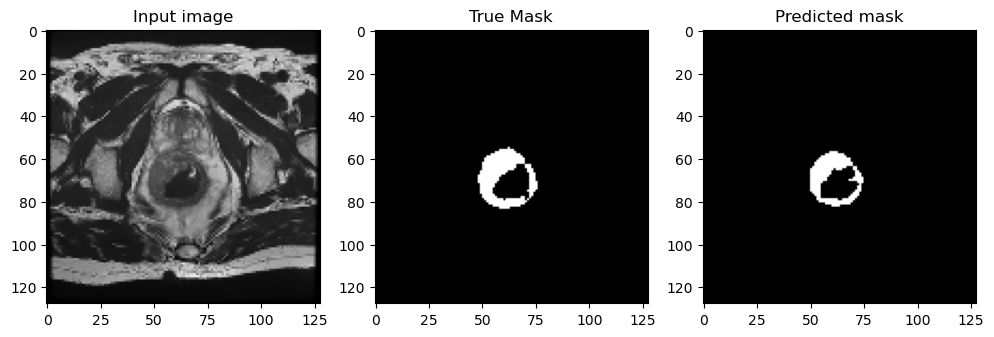

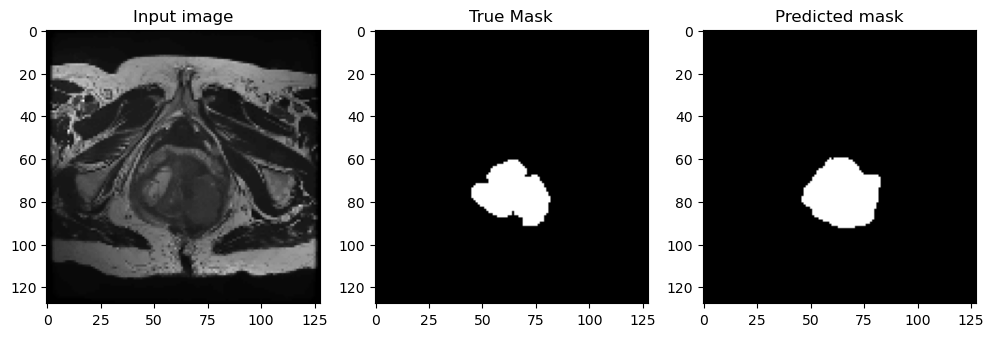

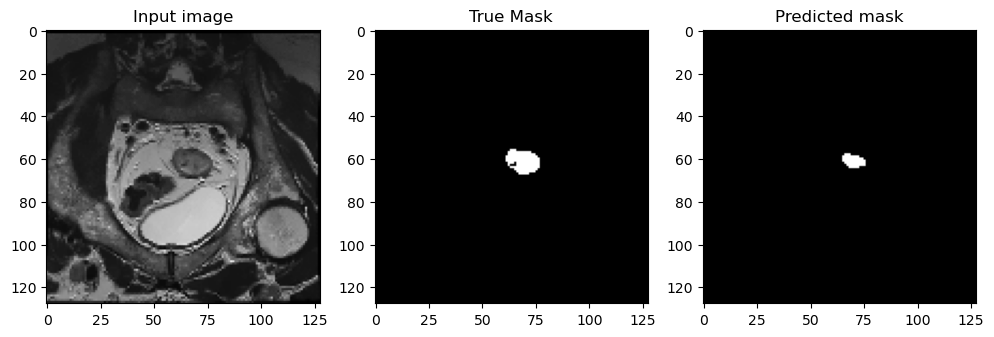

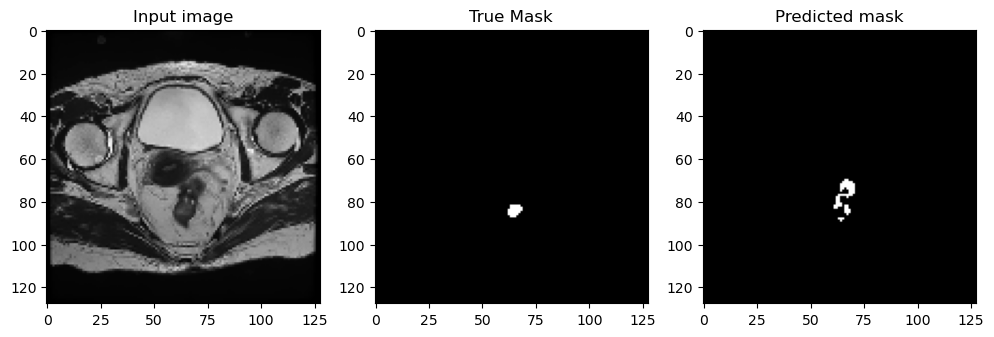

In [51]:
plt.style.use('default')

show_prediction(test_generator, 30)